# **Assigment 1 - Computer Vision**

André Azevedo Soares - up202006516

Daniel Alberto Soares Ganicho - up202006518

Diogo Francisco da Cruz Pereira - up202006588

In [1]:
# Imports for the project

import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import _cm
from matplotlib import colors 
import pandas as pd
import os
from sewar.full_ref import mse, rmse, psnr, uqi, ssim, ergas, scc, rase, sam, msssim, vifp
#from google.colab.patches import cv2_imshow
#from skimage import io
from PIL import Image
import time
import glob

In [2]:
# termination criteria
criteria = (cv.TermCriteria_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

#prepare object points
objp = np.zeros((7*4, 3), np.float32)
objp[:,:2] = np.mgrid[0:4,0:7].T.reshape(-1,2)

# Arrays to store object points and image points from all images
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane

images = glob.glob('CV_Assignment/assign1/calib/*.png')

for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv.findChessboardCorners(gray, (4,7), None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)      
        
        corners2 = cv.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        
        # Draw and display the corners
        img = cv.drawChessboardCorners(img, (4,7), corners2, ret)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        
        # print(fname)
        # plt.imshow(img)
        # plt.axis('off')
        # plt.show()
        cv.waitKey(500)
        
# Camera calibration, obtaining the parameters
retr, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2) / len(imgpoints[i])
    mean_error += error

# Printing parameters
print('Intrinsic matrix:')
print('{0} \n'.format(mtx))

print('Distortion coeficients:')
print('{0} \n'.format(dist))

print('Re-projection error:')
print('{0} \n'.format(mean_error/len(objpoints)))


Intrinsic matrix:
[[449.25266298   0.         334.36045363]
 [  0.         451.38313609 272.36859872]
 [  0.           0.           1.        ]] 

Distortion coeficients:
[[ 2.02424753e-02 -5.19996162e-02  7.31650900e-05 -6.13311483e-04
   2.38560775e-02]] 

Re-projection error:
0.03674796435049111 



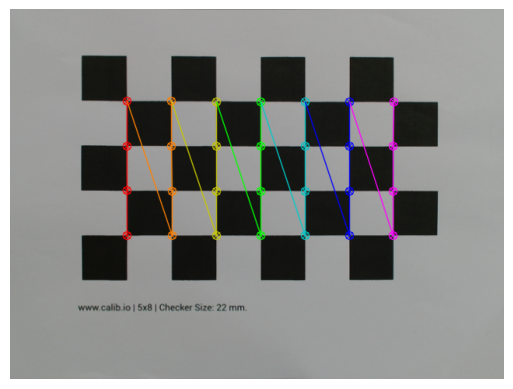

Distance between adjacent corners (in pixels): 57.4658317565918

Pixel to real-world ratio: 0.3828361928462982 mm/pixel

Extrinsic matrix:
[[ 0.01897286 -0.99975637 -0.01127987  0.84855162]
 [ 0.99936844  0.01862405  0.03026335 -4.10898645]
 [-0.0300459  -0.01184693  0.99947831  7.90140388]] 



In [3]:
img = cv.imread('CV_Assignment/assign1/data/chess.png')
h, w = img.shape[:2]
newcameramatrix, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w,h))

# undistort
# option-2
mapx, mapy = cv.initUndistortRectifyMap(mtx, dist, None, newcameramatrix, (w, h), 5)
dst = cv.remap(img, mapx, mapy, cv.INTER_LINEAR)

# option-1
#dst = cv.undistort(img, mtx, dist, None, newcameramatrix)

# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]

#plt.imshow(dst)
#plt.axis('off')
#plt.show()

dst_gray = cv.cvtColor(dst, cv.COLOR_BGR2GRAY)
ret, corners = cv.findChessboardCorners(dst_gray, (4,7), None)

if ret:
    corners = cv.cornerSubPix(dst_gray, corners, (11, 11), (-1, -1), criteria)
    
    cv.drawChessboardCorners(dst, (4,7), corners, ret)
    plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    
    corner1 = corners[0][0]
    corner2 = corners[1][0]
    
    pixel_distance = np.linalg.norm(corner1 - corner2)
    
    print(f"Distance between adjacent corners (in pixels): {pixel_distance}\n")
    
    square_size_real_world = 22 # Each square is 22 mm in real life
    pixel_to_real_world_ratio = square_size_real_world / pixel_distance
    print(f"Pixel to real-world ratio: {pixel_to_real_world_ratio} mm/pixel\n")
    
    rotation_matrix, _ = cv.Rodrigues(rvecs[0])
    translation_vector = tvecs[0]
    extrinsic_matrix = np.hstack((rotation_matrix, translation_vector))
    
    print('Extrinsic matrix:')
    print('{0} \n'.format(extrinsic_matrix))
    
else:
    print("Chessboard corners not found")

# **3)a)**

CV_Assignment/assign1/data/white_isolated\blue.png


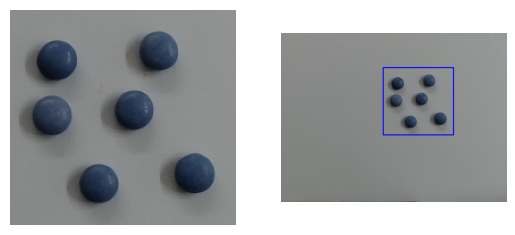

CV_Assignment/assign1/data/white_isolated\blue_nut.png


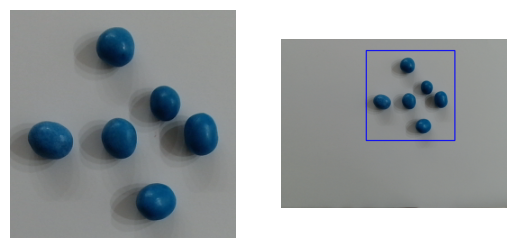

CV_Assignment/assign1/data/white_isolated\brown.png


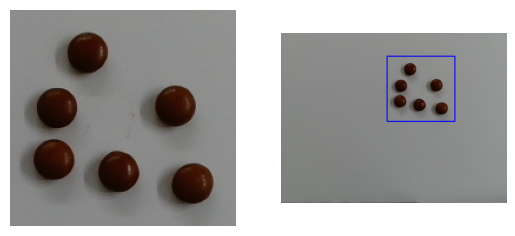

CV_Assignment/assign1/data/white_isolated\brown_nut.png


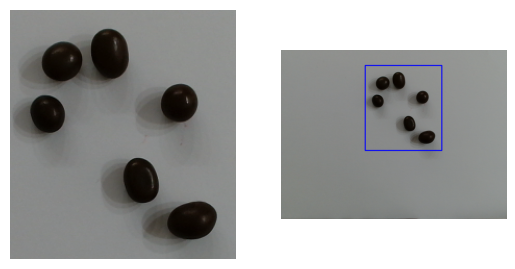

CV_Assignment/assign1/data/white_isolated\green.png


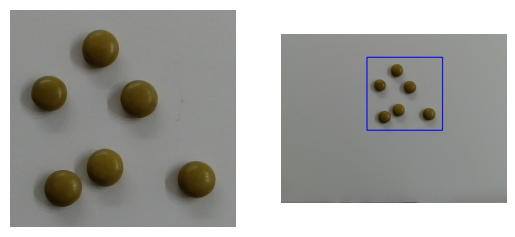

CV_Assignment/assign1/data/white_isolated\green_nut.png


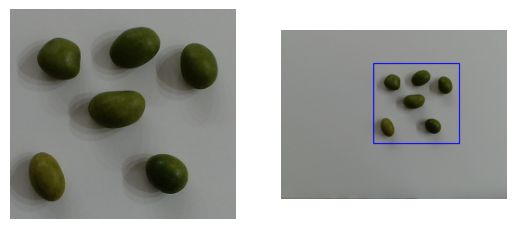

CV_Assignment/assign1/data/white_isolated\red.png


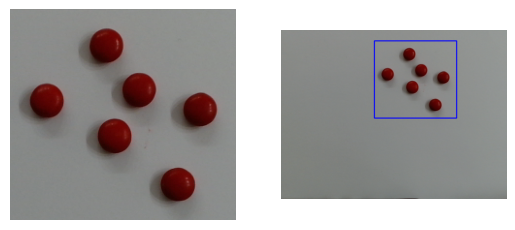

CV_Assignment/assign1/data/white_isolated\red_nut.png


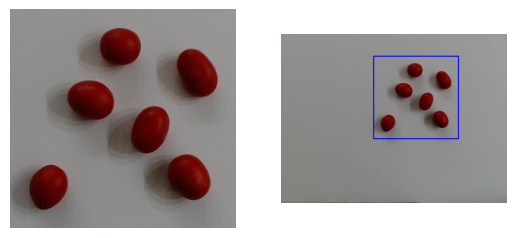

CV_Assignment/assign1/data/white_isolated\yellow.png


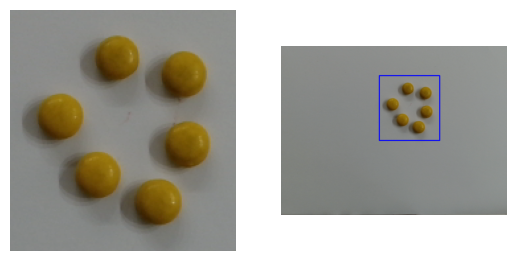

CV_Assignment/assign1/data/white_isolated\yellow_nut.png


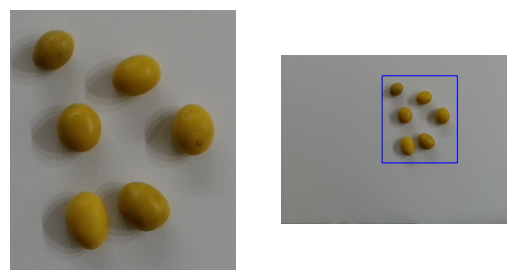

In [4]:
images_isolated = glob.glob('CV_Assignment/assign1/data/white_isolated/*.png')

lower_bound = np.array([0, 70, 0])    # Minimum H, S, V
upper_bound = np.array([115, 255, 180])  # Maximum H, S, V
    
for img in images_isolated:
    
    i = cv.imread(img)
    print(img)

    isolated_hsv = cv.cvtColor(i, cv.COLOR_BGR2HSV)
    
    mask = cv.inRange(isolated_hsv, lower_bound, upper_bound)

    result = cv.bitwise_and(i, i, mask=mask)
    
    output_image = i.copy()
    
    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    max_x = 0
    min_x = 20000
    max_y = 0
    min_y = 20000
    
    for cnt in contours:
        if(cv.contourArea(cnt) < 20):
            continue
        
        for point in cnt:
            x, y = point[0]
            
            if x > max_x:
                max_x = x
            elif x < min_x:
                min_x = x
                
            if y > max_y:
                max_y = y
            elif y < min_y:
                min_y = y   
                
                
    bound = 20 
    max_x = max_x + bound
    min_x = min_x - bound
    max_y = max_y + bound
    min_y = min_y - bound
    
    aux = i[min_y:max_y, min_x:max_x]
    
    i_copy = i.copy()    
    cv.rectangle(i_copy, (min_x,min_y), (max_x,max_y), (255, 0, 0), 2)
        
    plt.subplot(1,2,1)
    plt.imshow(cv.cvtColor(aux, cv.COLOR_RGB2BGR))
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(cv.cvtColor(i_copy, cv.COLOR_RGB2BGR))
    plt.axis('off')
    plt.show()

# **3)b)**

CV_Assignment/assign1/data/white_isolated\blue.png


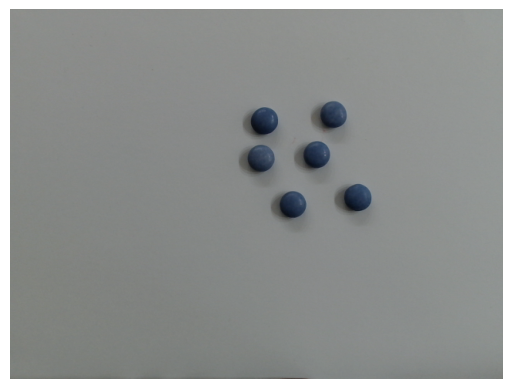

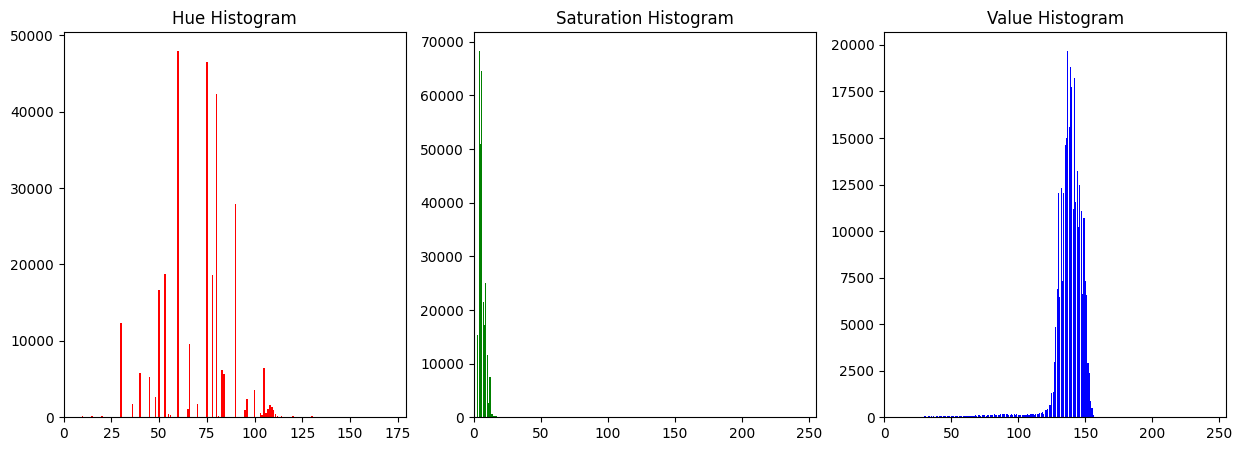

CV_Assignment/assign1/data/white_isolated\blue_nut.png


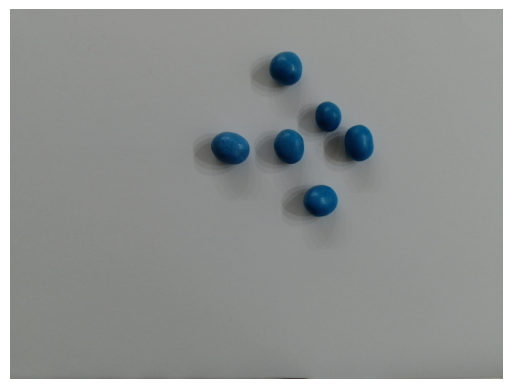

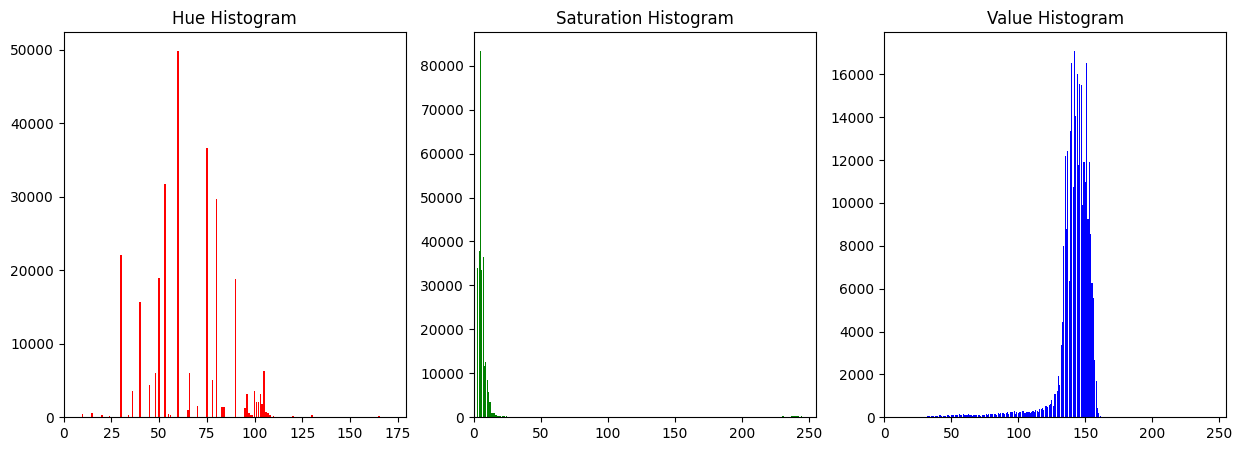

CV_Assignment/assign1/data/white_isolated\brown.png


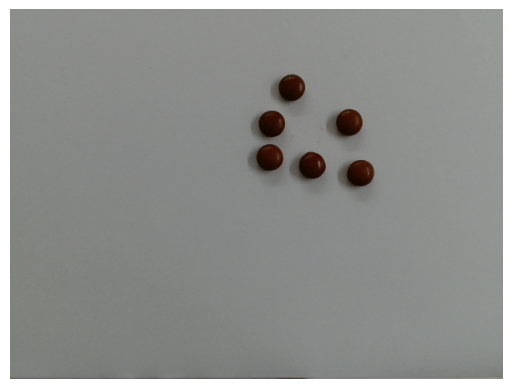

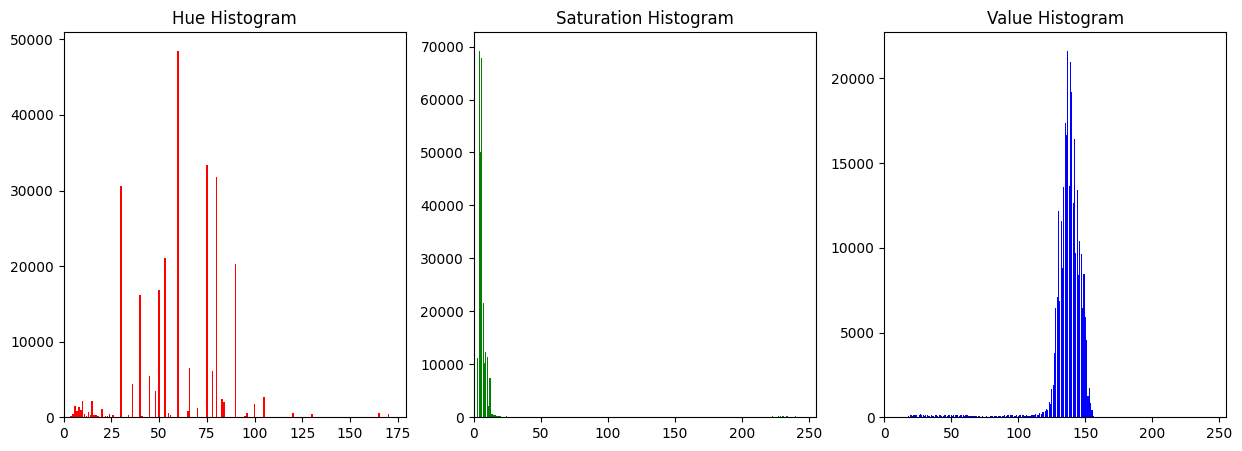

CV_Assignment/assign1/data/white_isolated\brown_nut.png


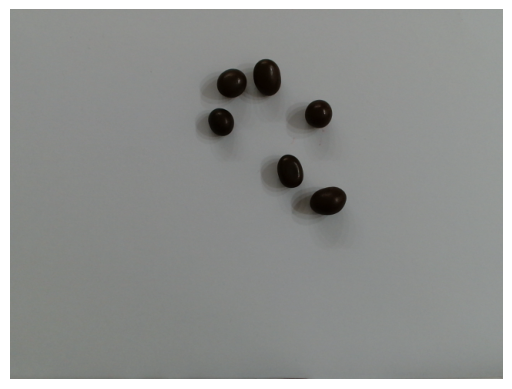

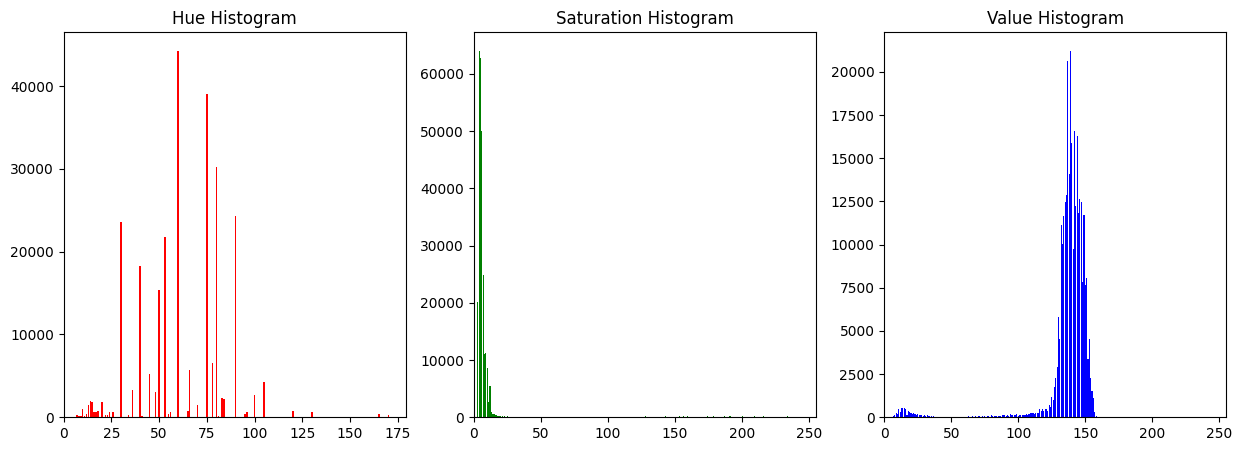

CV_Assignment/assign1/data/white_isolated\green.png


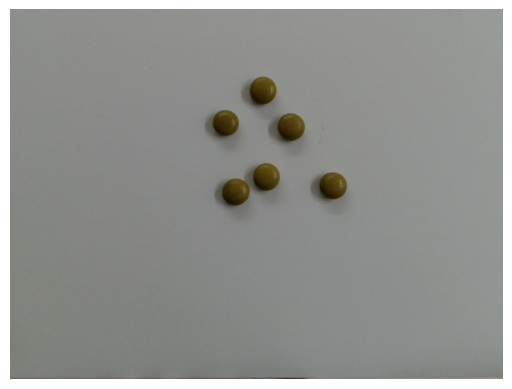

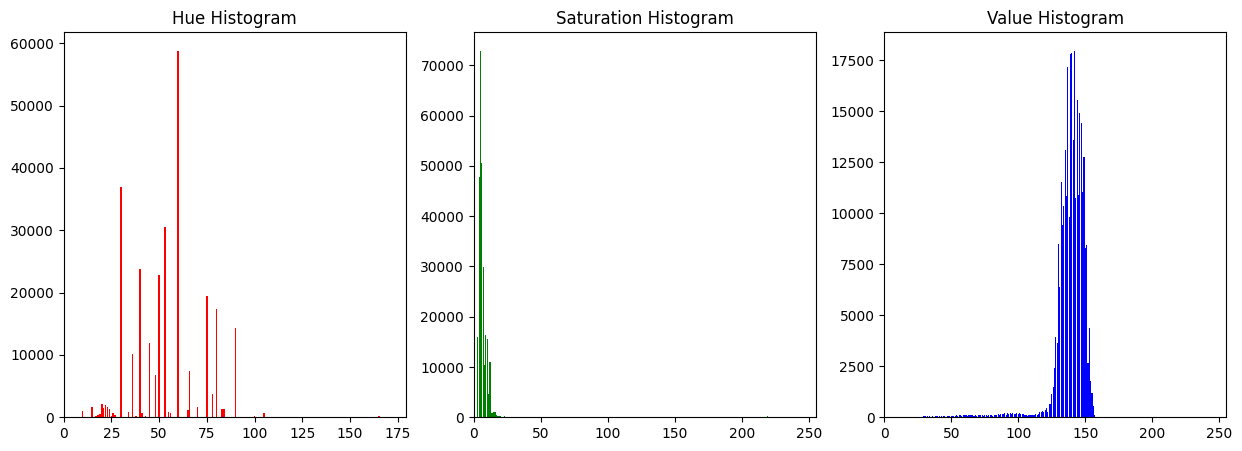

CV_Assignment/assign1/data/white_isolated\green_nut.png


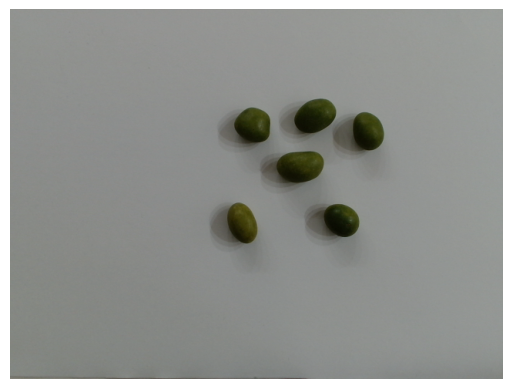

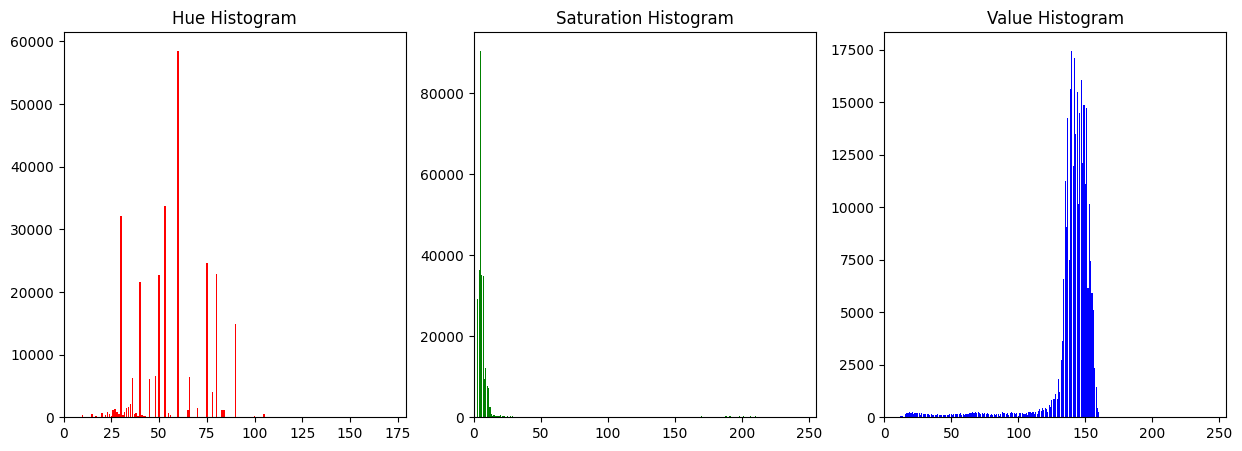

CV_Assignment/assign1/data/white_isolated\red.png


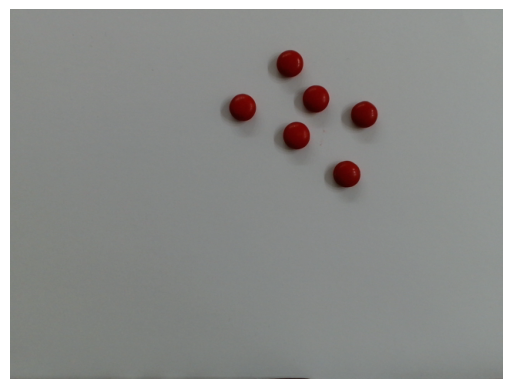

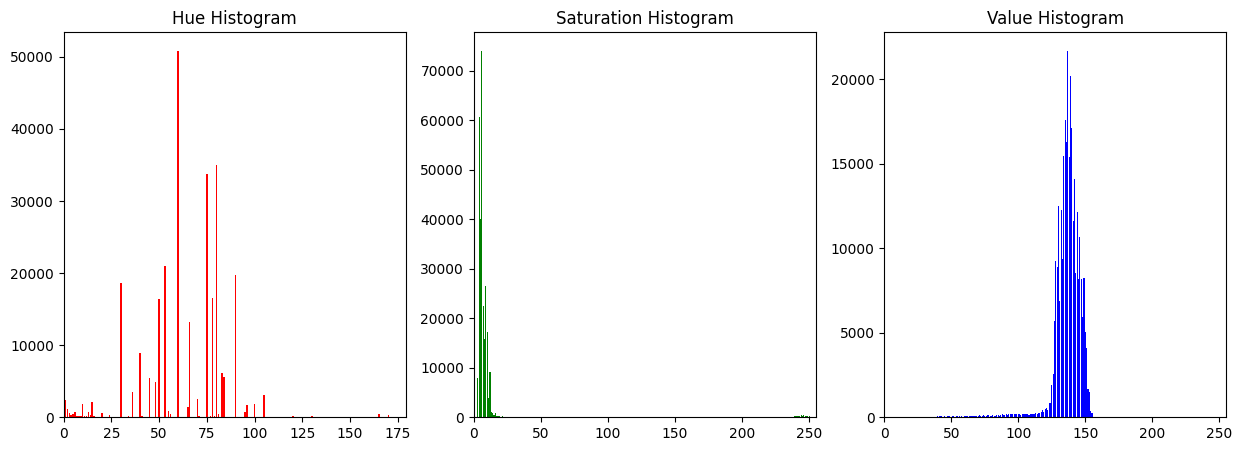

CV_Assignment/assign1/data/white_isolated\red_nut.png


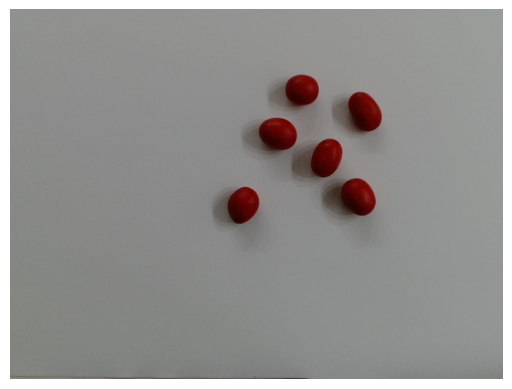

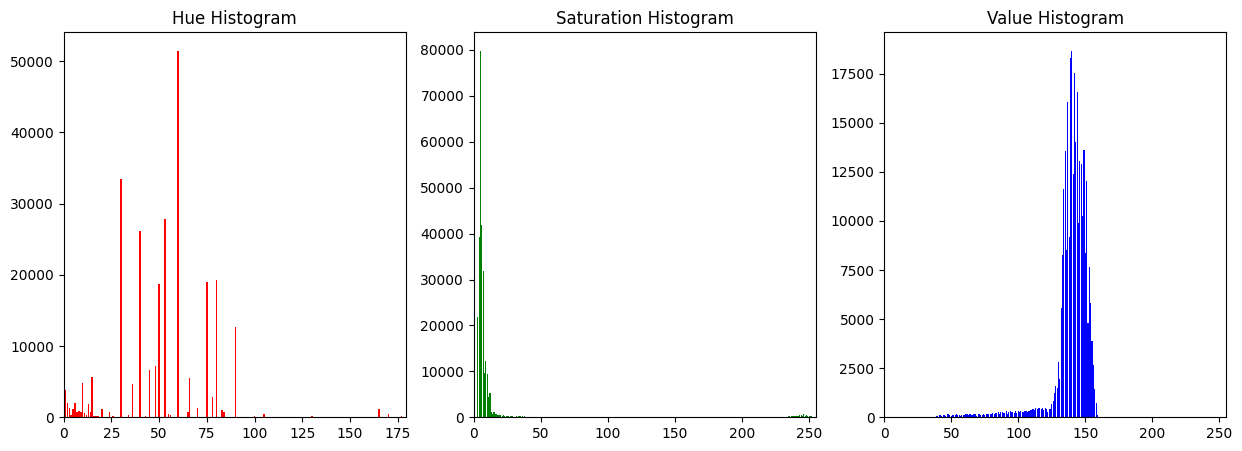

CV_Assignment/assign1/data/white_isolated\yellow.png


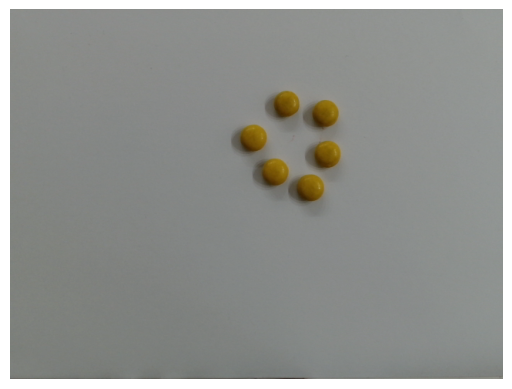

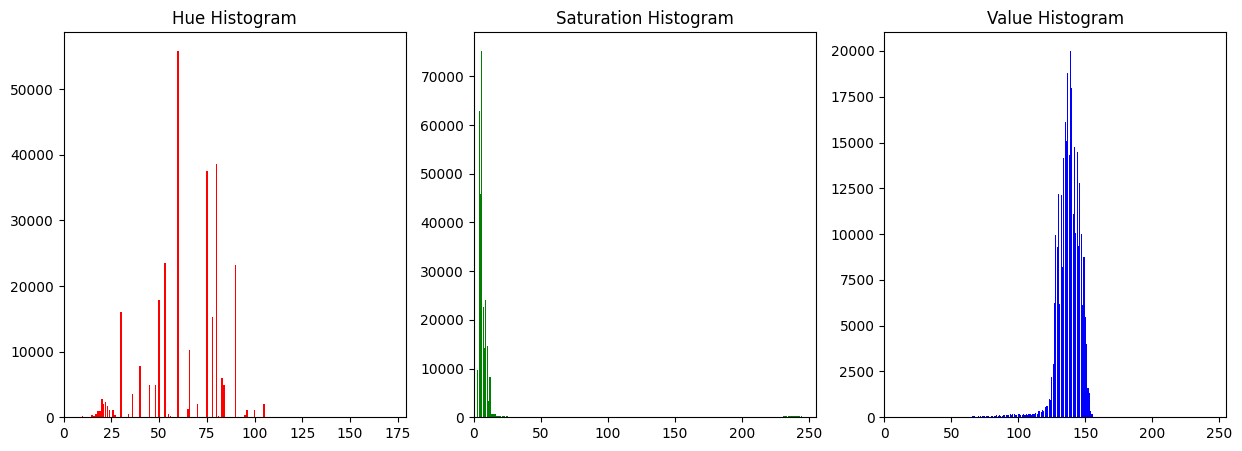

CV_Assignment/assign1/data/white_isolated\yellow_nut.png


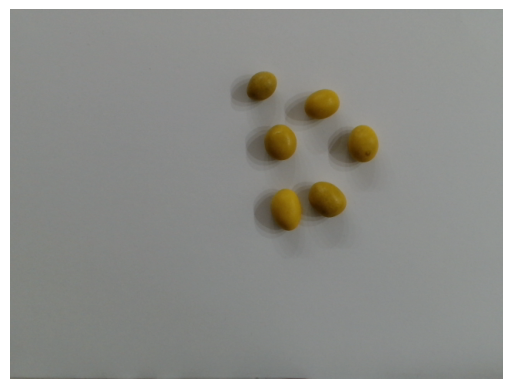

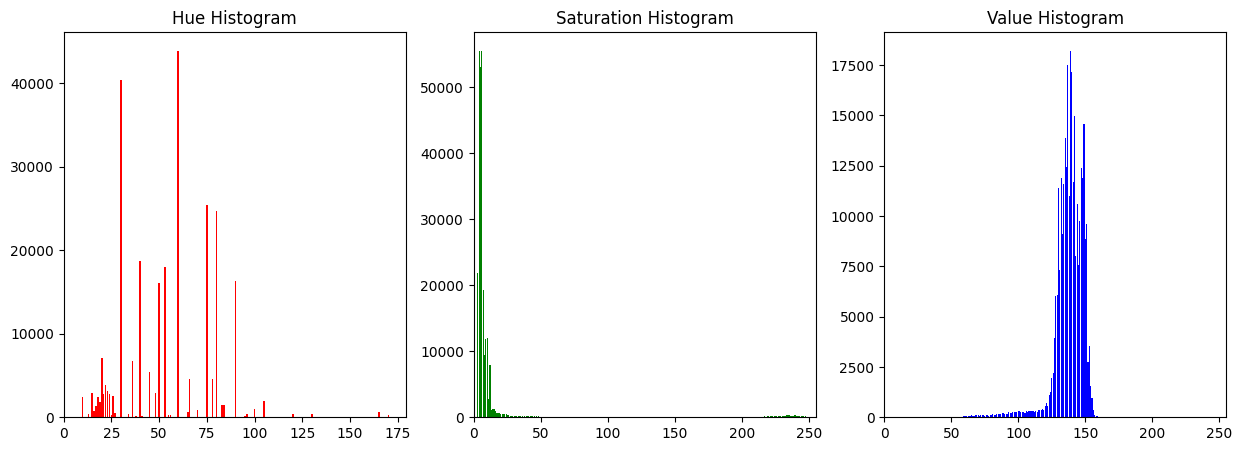

In [5]:
"""images_path = glob.glob('CV_Assignment/assign1/data/white_isolated/*.png')

for img in images_path:
    i = cv.imread(img)
    print(img)
    
    i_hsv = cv.cvtColor(i, cv.COLOR_BGR2HSV)
    
    h, s, v = cv.split(i_hsv)
    
    h_hist = cv.calcHist([h], [0], None, [180], [0, 179])
    s_hist = cv.calcHist([s], [0], None, [256], [0, 255])
    v_hist = cv.calcHist([v], [0], None, [256], [0, 255])
    
    plt.imshow(cv.cvtColor(i, cv.COLOR_RGB2BGR))
    plt.axis('off')
    plt.show()
    
    plt.figure(figsize=(15,5))
    
    plt.subplot(1,3,1)
    plt.plot(h_hist, color='red')
    plt.title('Hue Histogram')
    plt.xlim([0, 179])
    plt.subplot(1,3,2)
    plt.plot(s_hist, color='green')
    plt.title('Saturation Histogram')
    plt.xlim([0, 255])
    plt.subplot(1,3,3)
    plt.plot(v_hist, color='blue')
    plt.title('Value Histogram')
    plt.xlim([0, 255])
    plt.show()

"""
images_path = glob.glob('CV_Assignment/assign1/data/white_isolated/*.png')     #template de histogramas (estrutura correta)

for img in images_path:
    i = cv.imread(img)
    print(img)
    
    # Converter para HSV
    i_hsv = cv.cvtColor(i, cv.COLOR_BGR2HSV)
    
    # Separar os canais H, S, V
    h, s, v = cv.split(i_hsv)
    
    # Calcular os histogramas
    h_hist = cv.calcHist([h], [0], None, [180], [0, 179])
    s_hist = cv.calcHist([s], [0], None, [256], [0, 255])
    v_hist = cv.calcHist([v], [0], None, [256], [0, 255])
    
    # Mostrar a imagem
    plt.imshow(cv.cvtColor(i, cv.COLOR_RGB2BGR))
    plt.axis('off')
    plt.show()
    
    # Exibir os histogramas como barras
    plt.figure(figsize=(15, 5))
    
    # Histogramas em formato de barras
    plt.subplot(1, 3, 1)
    plt.bar(range(180), h_hist[:, 0], color='red')
    plt.title('Hue Histogram')
    plt.xlim([0, 179])
    
    plt.subplot(1, 3, 2)
    plt.bar(range(256), s_hist[:, 0], color='green')
    plt.title('Saturation Histogram')
    plt.xlim([0, 255])
    
    plt.subplot(1, 3, 3)
    plt.bar(range(256), v_hist[:, 0], color='blue')
    plt.title('Value Histogram')
    plt.xlim([0, 255])
    
    plt.show()
    


# **3)c)**

CV_Assignment/assign1/data/white_isolated\blue.png
Average area of detected contours: 1047.25 pixels²


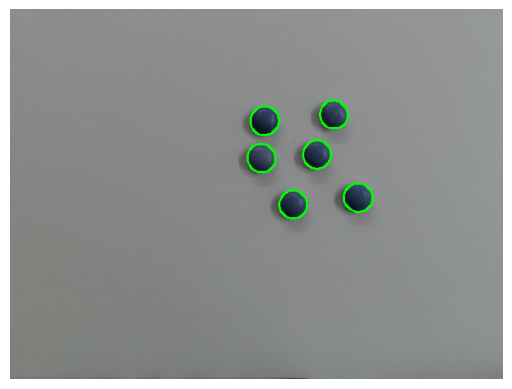

CV_Assignment/assign1/data/white_isolated\blue_nut.png
Average area of detected contours: 1521.67 pixels²


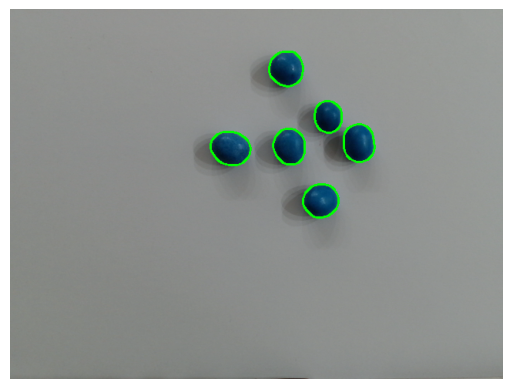

CV_Assignment/assign1/data/white_isolated\brown.png
Average area of detected contours: 1038.08 pixels²


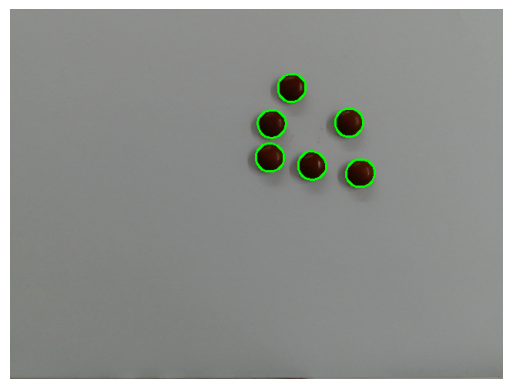

CV_Assignment/assign1/data/white_isolated\brown_nut.png
Average area of detected contours: 1182.00 pixels²


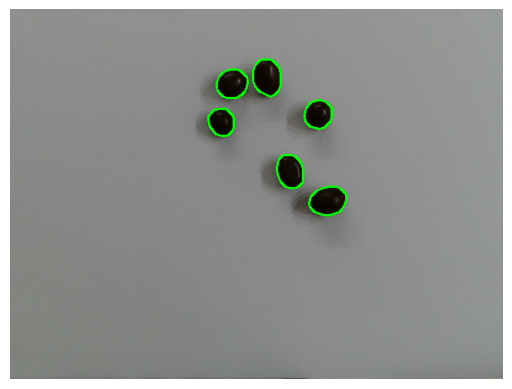

CV_Assignment/assign1/data/white_isolated\green.png
Average area of detected contours: 1063.17 pixels²


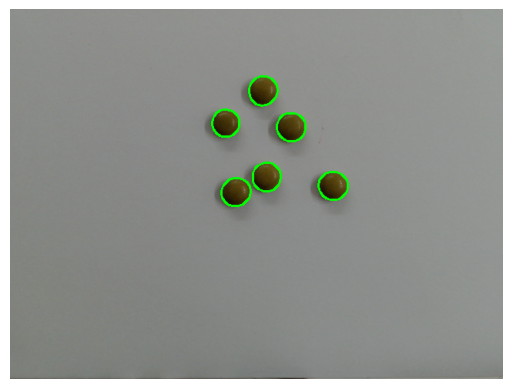

CV_Assignment/assign1/data/white_isolated\green_nut.png
Average area of detected contours: 1780.58 pixels²


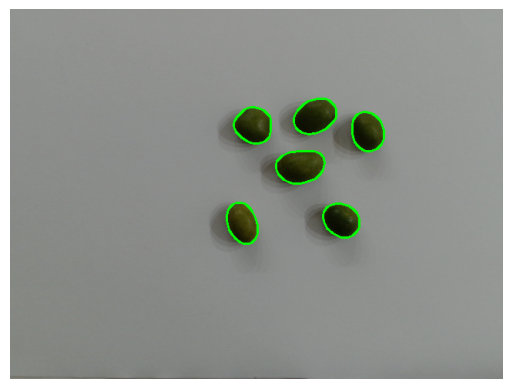

CV_Assignment/assign1/data/white_isolated\red.png
Average area of detected contours: 1103.25 pixels²


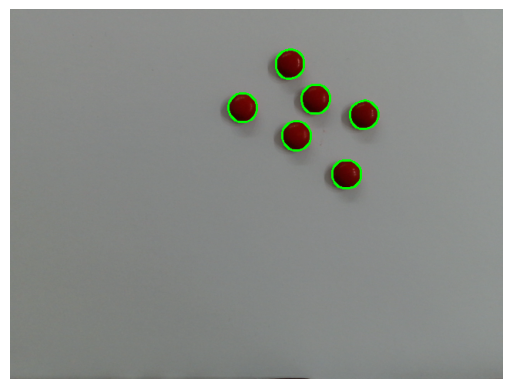

CV_Assignment/assign1/data/white_isolated\red_nut.png
Average area of detected contours: 1724.67 pixels²


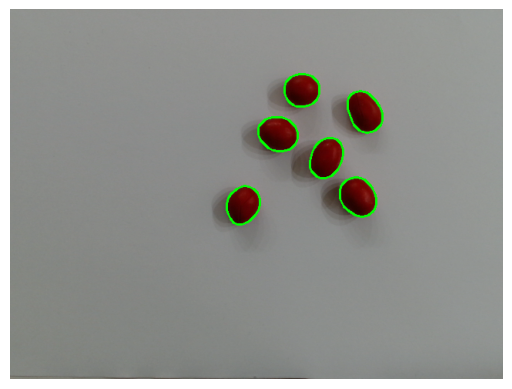

CV_Assignment/assign1/data/white_isolated\yellow.png
Average area of detected contours: 1093.92 pixels²


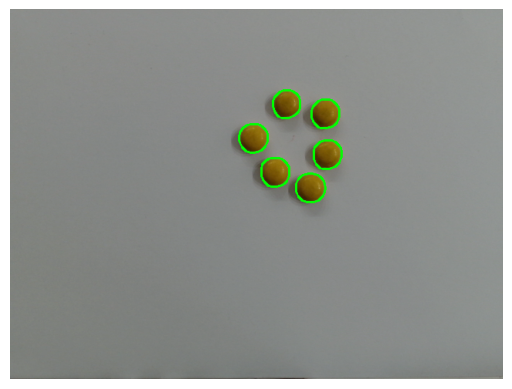

CV_Assignment/assign1/data/white_isolated\yellow_nut.png
Average area of detected contours: 1667.67 pixels²


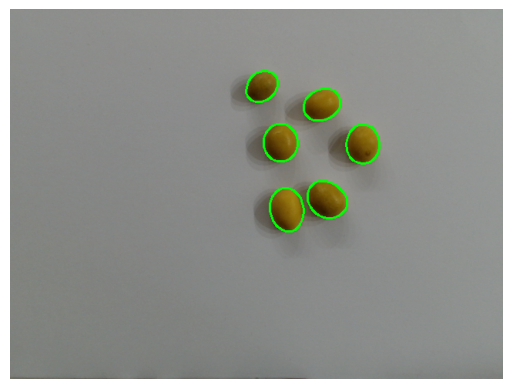

In [6]:
# Caminho das imagens
images_isolated = glob.glob('CV_Assignment/assign1/data/white_isolated/*.png')

all_MM_areas = []
all_average_areas = []

# Definir kernels
kernel = np.ones((5, 5), np.uint8)

kernel_test = np.array([[0, 0, 0], 
                        [0, 4, 0], 
                        [0, 0, 0]])

kernel_to_fill = np.array([[0, 1, 0], 
                           [1, 1, 1], 
                           [0, 1, 0]], dtype=np.uint8)

for image in images_isolated:
    
    i = cv.imread(image)
    print(image)
    
    # Converter para HSV e escala de cinza
    i_hsv = cv.cvtColor(i, cv.COLOR_BGR2HSV)
    #gray = cv.cvtColor(i, cv.COLOR_BGR2GRAY)
    
    h, s, v = cv.split(i_hsv)
    
    # Ajustar a saturação
    s = np.clip(s * 0.3, 0, 255).astype(np.uint8)
    
    # Aplicar o filtro
    s = cv.filter2D(s, -1, kernel_test)
    
    # Suavização adicional para reduzir ruído
    s = cv.GaussianBlur(s, (7, 7), 0)
        
    # Ajustar novamente a saturação
    s = np.clip(s * 0.4, 0, 255).astype(np.uint8)
    
    # Detecção de bordas usando Canny (ajustar thresholds)
    # Valor original a 55
    s_canny = cv.Canny(s, 50, 120) 
    
    # Fechamento morfológico para "fechar" pequenas falhas nas bordas
    dilated_edges = cv.dilate(s_canny, kernel_to_fill, iterations=1)
    s_canny = cv.morphologyEx(dilated_edges, cv.MORPH_CLOSE, kernel_to_fill)
    
    # Encontrar contornos
    contours = cv.findContours(s_canny, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)[0]
    contoured_image = i.copy()
    
    image_areas = []
    
    for cnt in contours:
        # Ignorar pequenos contornos
        if(cv.contourArea(cnt) < 20):
            continue
        
        # Usar convexHull para garantir que o contorno seja bem fechado
        hull = cv.convexHull(cnt)

        # Aproximar contornos para suavizar
        epsilon = 0.002 * cv.arcLength(hull, True)
        approx = cv.approxPolyDP(hull, epsilon, True)
    
        # Desenhar contornos na imagem original
        cv.drawContours(contoured_image, [approx], -1, (0, 255, 0), 2)
        
        image_areas.append(cv.contourArea(approx))
        
    all_MM_areas.append(image_areas)

    sum_contour = 0
    
    for contour_area in image_areas:
        sum_contour = sum_contour + contour_area    
        
    average_area = sum_contour / len(image_areas)
    print(f"Average area of detected contours: {average_area:.2f} pixels²")  
    
    all_average_areas.append(average_area)
        
    plt.imshow(cv.cvtColor(contoured_image, cv.COLOR_RGB2BGR))
    plt.axis('off')
    plt.show()

# **3)d)**

In [7]:
all_std = []

for i in all_MM_areas:
    std_dev = np.std(i)
    all_std.append(std_dev)

data_area = [
    {'Type': 'No Nut', 'Color': 'Blue', 'Average Area (mm²)': all_average_areas[0]/(pixel_to_real_world_ratio*pixel_to_real_world_ratio), 'Standard Deviation (mm²)': all_std[0]/(pixel_to_real_world_ratio*pixel_to_real_world_ratio)},
    {'Type': 'With Nut', 'Color': 'Blue', 'Average Area (mm²)': all_average_areas[1]/(pixel_to_real_world_ratio*pixel_to_real_world_ratio), 'Standard Deviation (mm²)': all_std[1]/(pixel_to_real_world_ratio*pixel_to_real_world_ratio)},
    {'Type': 'No Nut', 'Color': 'Brown', 'Average Area (mm²)': all_average_areas[2]/(pixel_to_real_world_ratio*pixel_to_real_world_ratio), 'Standard Deviation (mm²)': all_std[2]/(pixel_to_real_world_ratio*pixel_to_real_world_ratio)},
    {'Type': 'With Nut', 'Color': 'Brown', 'Average Area (mm²)': all_average_areas[3]/(pixel_to_real_world_ratio*pixel_to_real_world_ratio), 'Standard Deviation (mm²)': all_std[3]/(pixel_to_real_world_ratio*pixel_to_real_world_ratio)},
    {'Type': 'No Nut', 'Color': 'Green', 'Average Area (mm²)': all_average_areas[4]/(pixel_to_real_world_ratio*pixel_to_real_world_ratio), 'Standard Deviation (mm²)': all_std[4]/(pixel_to_real_world_ratio*pixel_to_real_world_ratio)},
    {'Type': 'With Nut', 'Color': 'Green', 'Average Area (mm²)': all_average_areas[5]/(pixel_to_real_world_ratio*pixel_to_real_world_ratio), 'Standard Deviation (mm²)': all_std[5]/(pixel_to_real_world_ratio*pixel_to_real_world_ratio)},
    {'Type': 'No Nut', 'Color': 'Red', 'Average Area (mm²)': all_average_areas[6]/(pixel_to_real_world_ratio*pixel_to_real_world_ratio), 'Standard Deviation (mm²)': all_std[6]/(pixel_to_real_world_ratio*pixel_to_real_world_ratio)},
    {'Type': 'With Nut', 'Color': 'Red', 'Average Area (mm²)': all_average_areas[7]/(pixel_to_real_world_ratio*pixel_to_real_world_ratio), 'Standard Deviation (mm²)': all_std[7]/(pixel_to_real_world_ratio*pixel_to_real_world_ratio)},
    {'Type': 'No Nut', 'Color': 'Yellow', 'Average Area (mm²)': all_average_areas[8]/(pixel_to_real_world_ratio*pixel_to_real_world_ratio), 'Standard Deviation (mm²)': all_std[8]/(pixel_to_real_world_ratio*pixel_to_real_world_ratio)},
    {'Type': 'With Nut', 'Color': 'Yellow', 'Average Area (mm²)': all_average_areas[9]/(pixel_to_real_world_ratio*pixel_to_real_world_ratio), 'Standard Deviation (mm²)': all_std[9]/(pixel_to_real_world_ratio*pixel_to_real_world_ratio)},
]

df_area = pd.DataFrame(data_area)

df_area['Average Area (mm²)'] = df_area['Average Area (mm²)'].map("{:.2f}".format)
df_area['Standard Deviation (mm²)'] = df_area['Standard Deviation (mm²)'].map("{:.2f}".format)

print(df_area.to_string(index=False))

    Type  Color Average Area (mm²) Standard Deviation (mm²)
  No Nut   Blue            7145.36                   152.65
With Nut   Blue           10382.30                  1234.80
  No Nut  Brown            7082.82                    61.73
With Nut  Brown            8064.76                  1143.16
  No Nut  Green            7253.96                   258.36
With Nut  Green           12148.88                  1257.56
  No Nut    Red            7527.45                   112.66
With Nut    Red           11767.36                   724.53
  No Nut Yellow            7463.77                   219.61
With Nut Yellow           11378.45                  1529.59


# **4)a)**

For each image in the folder, the code reads the image and makes a copy for later use. It then converts the image from BGR to HSV color space, a transformation that simplifies color-based segmentation. The saturation (S channel) is slightly reduced to make color segmentation more reliable, then thresholded to create a binary mask. This mask filters out low-saturation areas, leaving regions with a high concentration of color intact.

Next, the code isolates blue-colored M&Ms by thresholding the hue (H) channel and refining the result using morphological operations. The program identifies the contours of regions large enough to be M&Ms, then stores these contours as blue_contours for further analysis.

Red and yellow colors are processed next, with lower and upper HSV bounds defining a mask that isolates these colors. The program applies further morphological operations to clean up the mask, and contours of regions with adequate size are identified as red_yellow_contours.

Following this, the code uses another HSV range to identify green and brown M&Ms, creating a mask for these colors as well. Similar morphological operations are applied to refine the result, and contours that match the size requirements are stored as green_brown_contours.

With color contours identified, the program moves on to determine whether each M&M contains a nut. It evaluates the contour area and circularity, comparing the contour's shape to that of a circle. If an M&M's contour has an area below a set threshold and is close to circular, it is classified as “without nut.” Otherwise, the M&M is assumed to contain a nut.

For each identified M&M contour, the get_closest_color function is used to determine the closest matching color, which compares the color of a detected M&M with a set of predefined BGR color values. This function calculates the Euclidean distance between the M&M’s average BGR color and each of the predefined colors, such as red, yellow, green,blue and brown. The color with the smallest distance is returned as the closest match. Each M&M is then classified based on both color and nut status, with results stored in a dictionary, current_counts, which tracks counts for each color category as either "With Nut" or "Without Nut."

After processing each image, current_counts is appended to mm_counts, which accumulates data on M&Ms for the entire collection of images.

In [8]:
def get_closest_color(bgr):
    # Define a color mapping (BGR format)
    colors = {
        'Red': [5, 5, 130],
        'Blue': [100, 75, 60],
        'Blue': [105, 60, 5],
        'Yellow': [15, 125, 155],
        'Green': [35, 90, 85],
        'Green': [20, 85, 105],
        'Brown': [5, 25, 80],
        'Brown': [10, 15, 25]
    }

    closest_color = None
    min_distance = float('inf')  # Start with a large number

    for color_name, color_bgr in colors.items():
        distance = np.sqrt(np.sum((np.array(color_bgr) - np.array(bgr)) ** 2))
        
        # Update closest color if the distance is smaller
        if distance < min_distance:
            min_distance = distance
            closest_color = color_name

    return closest_color



images_isolated = glob.glob('CV_Assignment/assign1/data/white_mix/*.png')

lower_bound_ry = np.array([0, 180, 40])  
upper_bound_ry = np.array([30, 255, 255])

lower_bound_gb = np.array([0, 150, 0])  
upper_bound_gb = np.array([70, 255, 180])

i=0

all_contours = [[] for _ in range(len(images_isolated))]
mm_counts = []
    
for img in images_isolated:
    image = cv.imread(img)
    print(img)
    output_image = image.copy()
    
    image_hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    
    h, s, v = cv.split(image_hsv)
    
    ################################
    s = np.clip(s*0.75, 0, 255).astype('uint8')
    s_thresh = cv.threshold(s, 20, 255, cv.THRESH_BINARY)[1]
    s_thresh = cv.morphologyEx(s_thresh, cv.MORPH_ERODE, np.ones((3,3)).astype('uint8'))
    
    for y in range(s_thresh.shape[0]):
        for x in range(s_thresh.shape[1]):
            if s_thresh[y,x] == 0:
                image[y,x] = [0, 0, 0]
                                
    image_hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    
    h, s, v = cv.split(image_hsv)
    h_og = h
    s_og = s
    v_og = v
    
    ################################
    h = cv.threshold(h, 80, 255, cv.THRESH_BINARY_INV)[1]
    h = cv.morphologyEx(h, cv.MORPH_CLOSE, np.ones((3,3)).astype('uint8'))
    h = cv.morphologyEx(h, cv.MORPH_DILATE, np.ones((3,3)).astype('uint8'))
    
    h = cv.bitwise_not(h)
    
    contours = cv.findContours(h, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)[0]
    blue_contours = []
    
    if len(contours) > 0:
        for cnt in contours:
            if cv.contourArea(cnt) < 20:
                continue
            
            hull = cv.convexHull(cnt)

            epsilon = 0.002 * cv.arcLength(hull, True)
            approx = cv.approxPolyDP(hull, epsilon, True)

            blue_contours.append(approx)

    
    ################################        
    h = cv.bitwise_not(h) 
    s = cv.bitwise_and(s,h)
    v = cv.bitwise_and(v,h)
    h = cv.bitwise_not(h)
    s = cv.morphologyEx(s, cv.MORPH_ERODE, np.ones((3,3)).astype('uint8'))
    s_after = s
    v = cv.morphologyEx(v, cv.MORPH_ERODE, np.ones((3,3)).astype('uint8'))
    h[:, :] = 0
    image_hsv = cv.merge([h, s, v])
    bgr_image = cv.cvtColor(image_hsv, cv.COLOR_HSV2BGR)
    
    mask = cv.inRange(image_hsv, lower_bound_ry, upper_bound_ry)
    
    mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, np.ones((3,3)).astype('uint8'))
    mask = cv.morphologyEx(mask, cv.MORPH_ERODE, np.ones((3,3)).astype('uint8'))
    mask = cv.morphologyEx(mask, cv.MORPH_DILATE, np.ones((3,3)).astype('uint8'), iterations=2)
    
    result = cv.bitwise_and(bgr_image, bgr_image, mask=mask)
    
    contours = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)[0]
    red_yellow_contours = []
    
    if len(contours) > 0:
        for cnt in contours:
            if cv.contourArea(cnt) < 750:
                continue
            
            hull = cv.convexHull(cnt)

            epsilon = 0.002 * cv.arcLength(hull, True)
            approx = cv.approxPolyDP(hull, epsilon, True)
            
            red_yellow_contours.append(approx)
            
    ################################
    
    mask_to_remove = np.zeros(s_og.shape[:2], dtype=np.uint8)
    
    cv.drawContours(image, blue_contours, -1, (0, 0, 0), thickness=cv.FILLED)
    cv.drawContours(image, red_yellow_contours, -1, (0, 0, 0), thickness=cv.FILLED)
    
    image_hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    h, s, v = cv.split(image_hsv)
    
    s = np.clip(s*0.75, 0, 255).astype('uint8')
    s_thresh = cv.threshold(s, 70, 255, cv.THRESH_BINARY)[1]
    s_thresh = cv.morphologyEx(s_thresh, cv.MORPH_ERODE, np.ones((3,3)).astype('uint8'))
    
    for y in range(s_thresh.shape[0]):
        for x in range(s_thresh.shape[1]):
            if s_thresh[y,x] == 0:
                image[y,x] = [0, 0, 0]
                
    image_hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)    
    bgr_image = cv.cvtColor(image_hsv, cv.COLOR_HSV2BGR)

    mask = cv.inRange(image_hsv, lower_bound_gb, upper_bound_gb)
    mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, np.ones((3,3)).astype('uint8'))
    
    result = cv.bitwise_and(bgr_image, bgr_image, mask=mask)    
    
    contours = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)[0]
    green_brown_contours = []
    
    if len(contours) > 0:
        for cnt in contours:
            if cv.contourArea(cnt) < 200:
                continue
            
            hull = cv.convexHull(cnt)
            
            epsilon = 0.002 * cv.arcLength(hull, True)
            approx = cv.approxPolyDP(hull, epsilon, True)
            
            green_brown_contours.append(approx)
    
    for cnt in blue_contours:
        all_contours[i].append(cnt)
    
    for cnt in red_yellow_contours:
        all_contours[i].append(cnt)
        
    for cnt in green_brown_contours:
        all_contours[i].append(cnt)
        
    current_counts = {
        'Red': {'With Nut': 0, 'Without Nut': 0},
        'Yellow': {'With Nut': 0, 'Without Nut': 0},
        'Green': {'With Nut': 0, 'Without Nut': 0},
        'Blue': {'With Nut': 0, 'Without Nut': 0},
        'Brown': {'With Nut': 0, 'Without Nut': 0}
    }
        
    for cnt in all_contours[i]:
        # Nut / No Nut
        contour_area = cv.contourArea(cnt)
        perimeter = cv.arcLength(cnt, True)
        radius = perimeter / (2 * np.pi)
        circle_area = np.pi * (radius ** 2)

        circularity = contour_area / circle_area
        
        has_nut = not ((cv.contourArea(cnt) < 1135) and (0.90 < circularity < 1.1))        
        
        # Color  
        mask = np.zeros(output_image.shape[:2], dtype=np.uint8)
        cv.drawContours(mask, [cnt], -1, 255, thickness=cv.FILLED)
        roi = cv.bitwise_and(output_image, output_image, mask=mask)
        mean_color = cv.mean(output_image, mask=mask)[:3]
        color_name = get_closest_color(mean_color) #### Corrigir atribuição de cores de M&Ms
        
        if has_nut:
            current_counts[color_name]['With Nut'] += 1
        
        else:
            current_counts[color_name]['Without Nut'] += 1   
            
    mm_counts.append(current_counts)

    for color, counts in current_counts.items():
        print(f"{color} - with nut: {counts['With Nut']}, without nut: {counts['Without Nut']}")
    print("\n")
    i += 1

CV_Assignment/assign1/data/white_mix\all_rand.png
Red - with nut: 4, without nut: 4
Yellow - with nut: 5, without nut: 4
Green - with nut: 4, without nut: 4
Blue - with nut: 4, without nut: 5
Brown - with nut: 1, without nut: 6


CV_Assignment/assign1/data/white_mix\blue_yellow_red.png
Red - with nut: 3, without nut: 3
Yellow - with nut: 0, without nut: 1
Green - with nut: 2, without nut: 3
Blue - with nut: 3, without nut: 3
Brown - with nut: 0, without nut: 0


CV_Assignment/assign1/data/white_mix\green_brown.png
Red - with nut: 0, without nut: 0
Yellow - with nut: 0, without nut: 0
Green - with nut: 0, without nut: 3
Blue - with nut: 0, without nut: 0
Brown - with nut: 3, without nut: 6




# **4)b)**

For every contour in each image, stored in the all_contours list, the code calculates the moments, which include the area and centroid coordinates. If the area is zero, it skips to the next contour to avoid errors. Otherwise, it computes the centroid coordinates based on the moments.

Then, the code draws each contour in green on the image and places a blue dot at the calculated centroid.

CV_Assignment/assign1/data/white_mix\all_rand.png


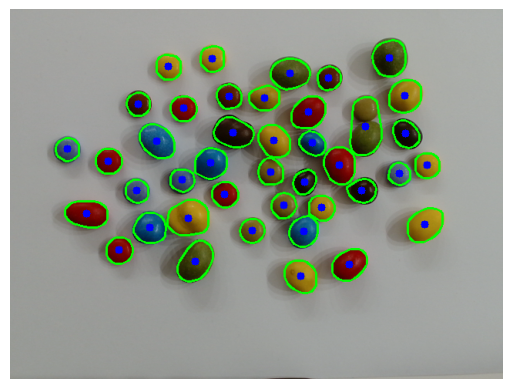

CV_Assignment/assign1/data/white_mix\blue_yellow_red.png


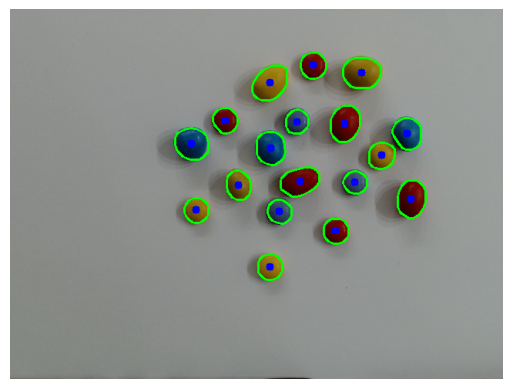

CV_Assignment/assign1/data/white_mix\green_brown.png


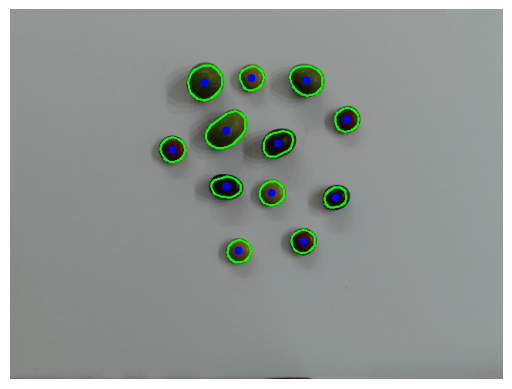

In [9]:
images_isolated = glob.glob('CV_Assignment/assign1/data/white_mix/*.png')

i = 0

for img in images_isolated:
    image = cv.imread(img)
    print(img)
    output_image = image.copy()
    
    for cnt in all_contours[i]:
        M = cv.moments(cnt)
        if M['m00'] == 0:
            continue
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])

        # Draw the contour and the centroid
        cv.drawContours(output_image, [cnt], -1, (0, 255, 0), 2)
        cv.circle(output_image, (cx, cy), 5, (255, 0, 0), -1)
        

    plt.imshow(cv.cvtColor(output_image, cv.COLOR_RGB2BGR))
    plt.axis('off')
    plt.show()
    
    i += 1

# **4)c)**

In [10]:
images_isolated = glob.glob('CV_Assignment/assign1/data/white_mix/*.png')

colors = ["Red", "Yellow", "Green", "Blue", "Brown"]
types = ["With Nut", "Without Nut"]

i = 0

for img in images_isolated:
    image = cv.imread(img)
    print(img)
    
    mm_table = pd.DataFrame(0, index=types, columns=colors)

    for color in colors:
        mm_table.loc["With Nut", color] = mm_counts[i][color]["With Nut"]
        mm_table.loc["Without Nut", color] = mm_counts[i][color]["Without Nut"]
        
    print(mm_table)
    print("\n")
    i += 1

CV_Assignment/assign1/data/white_mix\all_rand.png
             Red  Yellow  Green  Blue  Brown
With Nut       4       5      4     4      1
Without Nut    4       4      4     5      6


CV_Assignment/assign1/data/white_mix\blue_yellow_red.png
             Red  Yellow  Green  Blue  Brown
With Nut       3       0      2     3      0
Without Nut    3       1      3     3      0


CV_Assignment/assign1/data/white_mix\green_brown.png
             Red  Yellow  Green  Blue  Brown
With Nut       0       0      0     0      3
Without Nut    0       0      3     0      6




# **4)d)**

With the method we implemented, we encountered two limitations:

1. The model encounters difficulties detecting contours when two M&M's are touching each other, or too close to each other, or when the own shadow of a M&M is too intense.

2. The method has also issues with distinguishing colors due to the color mapping defined in the get_closest_color function.


# **4)e)**


To improve the sorting process, the M&M factory should use a black background to minimize shadow interference and create a consistent, shadow-free imaging environment. Positioning a light source at a 90º angle to the base will enhance the definition of each M&M, making edges easier to detect during image analysis. High-resolution cameras are essential for capturing detailed features, which improves accuracy in color and shape identification. Additionally, implementing a photometric calibration process will standardize color consistency across images, accounting for changes in lighting and ensuring reliable color-based sorting.


# **5)a)**

CV_Assignment/assign1/data/brown_mix/brown_most.png
Red - with nut: 0, without nut: 0
Yellow - with nut: 5, without nut: 6
Green - with nut: 16, without nut: 12
Blue - with nut: 6, without nut: 8
Brown - with nut: 0, without nut: 0


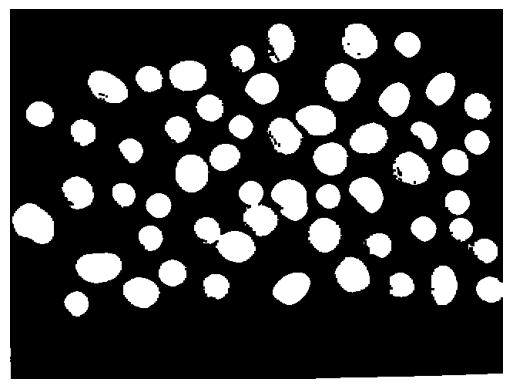

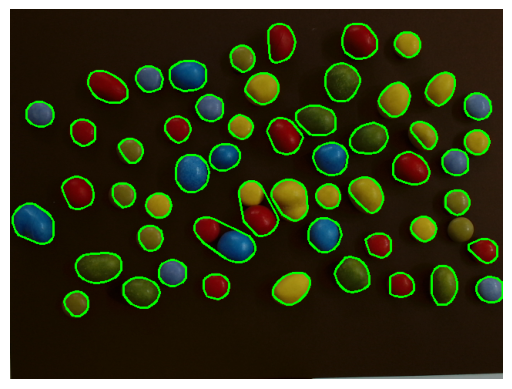

In [22]:
image_path = 'CV_Assignment/assign1/data/brown_mix/brown_most.png'

image = cv.imread(image_path)
output_image = image.copy()
print(image_path)

image_hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)

lower_brown = np.array([5, 150, 0])
upper_brown = np.array([20, 255, 50])

mask_brown = cv.inRange(image_hsv, lower_brown, upper_brown)
mask_brown = cv.morphologyEx(mask_brown, cv.MORPH_DILATE, np.ones((3,3)).astype('uint8'))
mask_brown = cv.morphologyEx(mask_brown, cv.MORPH_OPEN, np.ones((3,3)).astype('uint8'))
mask_brown = cv.bitwise_not(mask_brown)

result = cv.bitwise_and(image, image, mask=mask_brown)

contours = cv.findContours(mask_brown, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)[0]
good_contours = []
    
if len(contours) > 0:
    for cnt in contours:
        if cv.contourArea(cnt) < 650 or cv.contourArea(cnt) > 100000:
            continue
        
        hull = cv.convexHull(cnt)
        
        epsilon = 0.002 * cv.arcLength(hull, True)
        approx = cv.approxPolyDP(hull, epsilon, True)
        
        good_contours.append(approx)
        cv.drawContours(output_image, [approx], -1, (0, 255, 0), 2)
        

current_counts_5 = {
        'Red': {'With Nut': 0, 'Without Nut': 0},
        'Yellow': {'With Nut': 0, 'Without Nut': 0},
        'Green': {'With Nut': 0, 'Without Nut': 0},
        'Blue': {'With Nut': 0, 'Without Nut': 0},
        'Brown': {'With Nut': 0, 'Without Nut': 0}
    }        

for cnt in good_contours:
    # Nut / No Nut
    contour_area = cv.contourArea(cnt)
    perimeter = cv.arcLength(cnt, True)
    radius = perimeter / (2 * np.pi)
    circle_area = np.pi * (radius ** 2)

    circularity = contour_area / circle_area
    
    has_nut = not ((cv.contourArea(cnt) < 1135) and (0.90 < circularity < 1.1))        
    
    # Color  
    mask = np.zeros(output_image.shape[:2], dtype=np.uint8)
    cv.drawContours(mask, [cnt], -1, 255, thickness=cv.FILLED)
    roi = cv.bitwise_and(output_image, output_image, mask=mask)
    mean_color = cv.mean(output_image, mask=mask)[:3]
    color_name = get_closest_color(mean_color) # Corrigir atribuição de cores de M&Ms
    
    if has_nut:
        current_counts_5[color_name]['With Nut'] += 1
    
    else:
        current_counts_5[color_name]['Without Nut'] += 1   

for color, counts in current_counts_5.items():
    print(f"{color} - with nut: {counts['With Nut']}, without nut: {counts['Without Nut']}")

plt.imshow(mask_brown, cmap='gray',)
plt.axis('off')
plt.show()
plt.imshow(cv.cvtColor(output_image, cv.COLOR_RGB2BGR))
plt.axis('off')
plt.show()

# **5)b)**

CV_Assignment/assign1/data/brown_mix/brown_most.png


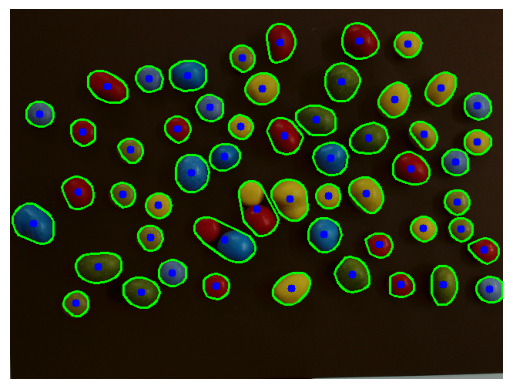

In [12]:
image_path = 'CV_Assignment/assign1/data/brown_mix/brown_most.png'

image = cv.imread(image_path)
output_image = image.copy()
print(image_path)

for cnt in good_contours:
    M = cv.moments(cnt)
    if M['m00'] == 0:
        continue
    cx = int(M['m10'] / M['m00'])
    cy = int(M['m01'] / M['m00'])

    # Draw the contour and the centroid
    cv.drawContours(output_image, [cnt], -1, (0, 255, 0), 2)
    cv.circle(output_image, (cx, cy), 5, (255, 0, 0), -1)
    

plt.imshow(cv.cvtColor(output_image, cv.COLOR_RGB2BGR))
plt.axis('off')
plt.show()

# **5)c)**

In [13]:
image_path = 'CV_Assignment/assign1/data/brown_mix/brown_most.png'

colors = ["Red", "Yellow", "Green", "Blue", "Brown"]
types = ["With Nut", "Without Nut"]

image = cv.imread(image_path)
print(image_path)

mm_table = pd.DataFrame(0, index=types, columns=colors)

for color in colors:
    mm_table.loc["With Nut", color] = current_counts_5[color]["With Nut"]
    mm_table.loc["Without Nut", color] = current_counts_5[color]["Without Nut"]
    
print(mm_table)
print("\n")

CV_Assignment/assign1/data/brown_mix/brown_most.png
             Red  Yellow  Green  Blue  Brown
With Nut       6       2      6     5      7
Without Nut    6       6      8     8      0


